In [1]:
import time
import traceback
from pathlib import Path
from typing import Optional

import fire
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pyfiglet import figlet_format
from sty import bg, ef, fg, rs
from tqdm import tqdm

from fetch_bitcoin_data import fetch_bitcoin_data
from metrics.base_metric import BaseMetric
from metrics.mvrv_z_score import MVRVMetric
from metrics.pi_cycle import PiCycleMetric
from metrics.puell_multiple import PuellMetric
from metrics.reserve_risk import ReserveRiskMetric
from metrics.rhodl_ratio import RHODLMetric
from metrics.rupl import RUPLMetric
from metrics.trolololo import TrolololoMetric
from metrics.two_year_moving_average import TwoYearMovingAverageMetric
from metrics.woobull_topcap_cvdd import WoobullMetric
from metrics.ma_log_rat import MALogRatMetric
from utils import format_percentage, get_color

In [2]:
pd.options.plotting.backend = "plotly"

In [3]:
def get_metrics() -> list[BaseMetric]:
    """
    Returns a list of available metrics to be calculated.
    """
    return [
        PiCycleMetric(),
        RUPLMetric(),
        RHODLMetric(),
        PuellMetric(),
        TwoYearMovingAverageMetric(),
        TrolololoMetric(),
        MVRVMetric(),
        ReserveRiskMetric(),
        WoobullMetric(),
        MALogRatMetric(),
    ]


def calculate_confidence_score(df: pd.DataFrame, cols: list[str]) -> pd.Series:
    """
    Calculate the confidence score for a DataFrame.

    This function takes in a DataFrame and a list of column names
    and returns a Series with the mean value of the specified columns for each row.

    Args:
        df: A pandas DataFrame.
        cols: A list of column names to include in the calculation.

    Returns:
        A pandas Series with the mean value for the specified columns for each row in the DataFrame.
    """
    return df[cols].mean(axis=1)


def run(json_file: str,
        charts_file: str,
        output_dir: Optional[str]) -> None:
    if output_dir is None:
        output_dir_path = Path.cwd()
    else:
        output_dir_path = Path(output_dir)

    json_file_path = output_dir_path / Path(json_file)
    charts_file_path = output_dir_path / Path(charts_file)

    if not output_dir_path.exists():
        output_dir_path.mkdir(mode=0o755, parents=True)

    df_bitcoin = fetch_bitcoin_data()
    df_bitcoin_org = df_bitcoin.copy()

    current_price = df_bitcoin['Price'].tail(1).values[0]
    print(f'Current Bitcoin price: ' + ef.b + fg.li_green + bg.da_green + f' $ {round(current_price):,} ' + rs.all)

    metrics = get_metrics()
    metrics_cols = []
    metrics_descriptions = []

    sns.set(font_scale=0.15, rc={
        # 'font.size': 6,
        'figure.titlesize': 8,
        'axes.titlesize': 5,
        'axes.labelsize': 4,
        'xtick.labelsize': 4,
        'ytick.labelsize': 4,
        'lines.linewidth': 0.5,
        'grid.linewidth': 0.3,

        'savefig.dpi': 1000,
        'figure.dpi': 300,
    })

    axes_per_metric = 2
    fig, axes = plt.subplots(len(metrics), axes_per_metric, figsize=(4 * axes_per_metric, 3 * len(metrics)))
    axes = axes.reshape(-1, axes_per_metric)
    plt.tight_layout(pad=14)

    for metric, ax in zip(metrics, axes):
        df_bitcoin[metric.name] = metric.calculate(df_bitcoin_org.copy(), ax).clip(0, 1)
        metrics_cols.append(metric.name)
        metrics_descriptions.append(metric.description)

    print('Generating charts…')
    print(charts_file_path)
    plt.savefig(charts_file_path)

    confidence_col = 'Confidence'

    df_result = pd.DataFrame(df_bitcoin[['Date', 'Price'] + metrics_cols])
    df_result.set_index('Date', inplace=True)
    df_result[confidence_col] = calculate_confidence_score(df_result, metrics_cols)
    df_result \
        .to_json(json_file_path,
                 double_precision=4,
                 date_unit='s',
                 indent=2)

    df_result_last = df_result.tail(1)
    confidence_details = {description: df_result_last[name].iloc[0]
                          for name, description in
                          zip(metrics_cols, metrics_descriptions)}

    print('\n' + ef.b + ':: Confidence we are at the peak ::' + rs.all)
    print(
        fg.cyan + ef.bold +
        figlet_format(
            format_percentage(df_result_last[confidence_col].iloc[0], ''),
            font='univers') + rs.all,
        end='')

    for description, value in confidence_details.items():
        if not np.isnan(value):
            print(fg.white + get_color(value) + f'{format_percentage(value)} ' + rs.all, end='')
            print(f' - {description}')

    print()
    print('Source code: ' + ef.u + fg.li_blue + 'https://github.com/Zaczero/CBBI' + rs.all)
    print('License: ' + ef.b + 'AGPL-3.0' + rs.all)
    print()


def run_and_retry(json_file: str = 'latest.json',
                  charts_file: str = 'charts.svg',
                  output_dir: Optional[str] = 'output',
                  max_attempts: int = 10,
                  sleep_seconds_on_error: int = 10) -> None:
    """
    Calculates the current CBBI confidence value alongside all the required metrics.
    Everything gets pretty printed to the current standard output and a clean copy
    is saved to a JSON file specified by the path in the ``json_file`` argument.
    A charts image is generated on the path specified by the ``charts_file`` argument
    which summarizes all individual metrics' historical data in a visual way.
    The execution is attempted multiple times in case an error occurs.

    Args:
        json_file: File path where the output is saved in the JSON format.
        charts_file: File path where the charts image is saved (formats supported by pyplot.savefig).
        output_dir: Directory path where the output is stored.
            If set to ``None`` then use the current working directory.
            If the directory does not exist, it will be created.
        max_attempts: Maximum number of attempts before termination. An attempt is counted when an error occurs.
        sleep_seconds_on_error: Duration of the sleep in seconds before attempting again after an error occurs.

    Returns:
        None
    """
    assert max_attempts > 0, 'Value of the max_attempts argument must be positive'
    assert sleep_seconds_on_error >= 0, 'Value of the sleep_seconds_on_error argument must be non-negative'

    for _ in range(max_attempts):
        try:
            run(json_file, charts_file, output_dir)
            exit(0)

        except Exception:
            print(fg.black + bg.yellow + ' An error has occurred! ' + rs.all)
            traceback.print_exc()

            print(f'\nRetrying in {sleep_seconds_on_error} seconds…', flush=True)
            for _ in tqdm(range(sleep_seconds_on_error)):
                time.sleep(1)

    print(f'Max attempts limit has been reached ({max_attempts}).')
    print(f'Better luck next time!')
    exit(-1)

In [2]:
# fire.Fire(run_and_retry)

In [4]:
df_bitcoin = fetch_bitcoin_data()
df_bitcoin_org = df_bitcoin.copy()
df_bitcoin_org

📈 Requesting historical Bitcoin data…


,Date,TotalBlocks,MinBlockID,MaxBlockID,TotalGeneration,TotalGenerationUSD,BlockGeneration,BlockGenerationUSD,Price,PriceLog,PriceLogInterp,Halving,NextHalvingBlock,DaysToHalving,NextHalvingDate,PriceHigh,PriceLow,DaysSincePriceHigh,DaysSincePriceLow,DaysSinceHalving
0,2011-06-27,169,133430,133598,8450.00,1.317355e+05,50.00,779.5000,15.590000,2.746630,0.467525,0,210000,530 days 13:39:59.999961600,2012-12-08 13:39:59.999961600,0,0,NaN,NaN,NaN
1,2011-06-28,160,133599,133758,8000.00,1.360800e+05,50.00,850.5000,17.010000,2.833801,0.473069,0,210000,529 days 10:59:59.999971200,2012-12-08 10:59:59.999971200,0,0,NaN,NaN,NaN
2,2011-06-29,172,133759,133930,8600.00,1.455980e+05,50.00,846.5000,16.930000,2.829087,0.472769,0,210000,528 days 06:20:00.000009600,2012-12-08 06:20:00.000009600,0,0,NaN,NaN,NaN
3,2011-06-30,191,133931,134121,9550.00,1.612040e+05,50.00,843.9999,16.879998,2.826129,0.472581,0,210000,526 days 22:30:00,2012-12-07 22:30:00.000000000,0,0,NaN,NaN,NaN
4,2011-07-01,173,134122,134294,8650.00,1.428115e+05,50.00,825.5000,16.139802,2.781288,0.469729,0,210000,525 days 17:39:59.999990400,2012-12-07 17:39:59.999990400,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4572,2024-01-02,131,823941,824071,818.75,3.655391e+07,6.25,279037.5000,44646.000000,10.706520,0.973720,0,840000,110 days 14:50:00.000038399,2024-04-21 14:50:00.000038399,0,0,784.0,406.0,1331.0
4573,2024-01-03,158,824072,824229,987.50,4.444540e+07,6.25,281300.0000,45008.000000,10.714596,0.974234,0,840000,109 days 12:29:59.999971200,2024-04-21 12:29:59.999971200,0,0,785.0,407.0,1332.0
4574,2024-01-04,170,824230,824399,1062.50,4.554194e+07,6.25,267893.7500,42863.000000,10.665764,0.971129,0,840000,108 days 08:10:00.000019199,2024-04-21 08:10:00.000019199,0,0,786.0,408.0,1333.0
4575,2024-01-05,138,824400,824537,862.50,3.816735e+07,6.25,276575.0000,44252.000000,10.697656,0.973157,0,840000,107 days 09:09:59.999961600,2024-04-21 09:09:59.999961600,0,0,787.0,409.0,1334.0


In [8]:
metrics = get_metrics()
metrics_cols = []
metrics_descriptions = []

for metric in metrics:
    print(metric.name, "-", metric.description)

PiCycle - Pi Cycle Top Indicator
RUPL - RUPL/NUPL Chart
RHODL - RHODL Ratio
Puell - Puell Multiple
2YMA - 2 Year Moving Average
Trolololo - Bitcoin Trolololo Trend Line
MVRV - MVRV Z-Score
ReserveRisk - Reserve Risk
Woobull - Woobull Top Cap vs CVDD
MALogRat - Moving Average Log Ratio


PiCycle Pi Cycle Top Indicator
RUPL RUPL/NUPL Chart
RHODL RHODL Ratio
Puell Puell Multiple
2YMA 2 Year Moving Average
Trolololo Bitcoin Trolololo Trend Line
MVRV MVRV Z-Score
ReserveRisk Reserve Risk
Woobull Woobull Top Cap vs CVDD
MALogRat Moving Average Log Ratio


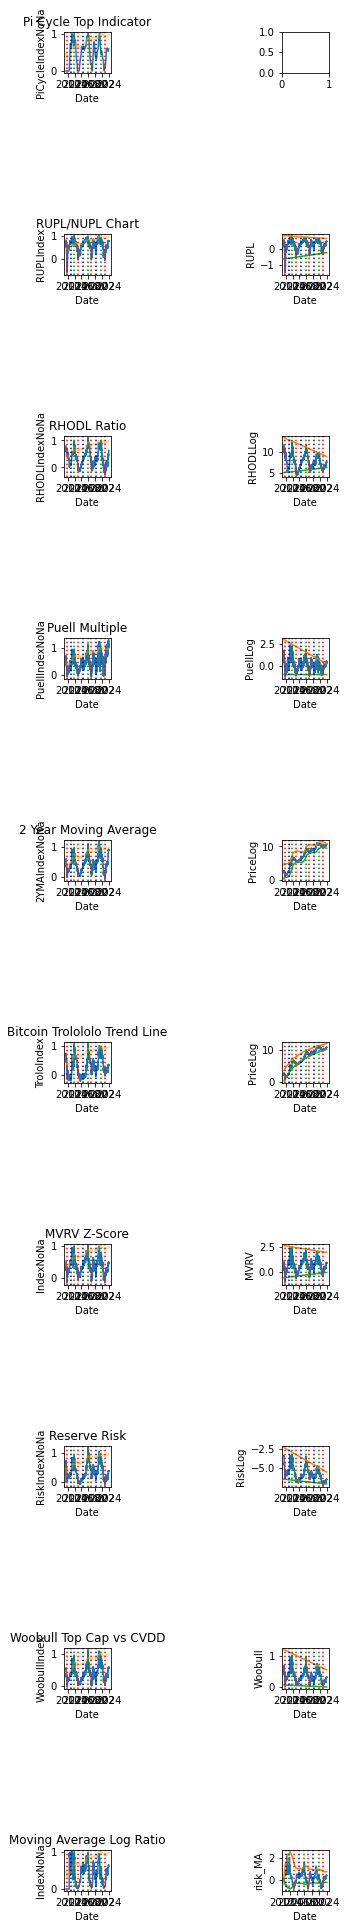

In [91]:
axes_per_metric = 2
fig, axes = plt.subplots(len(metrics), axes_per_metric, figsize=(4 * axes_per_metric, 3 * len(metrics)))
axes = axes.reshape(-1, axes_per_metric)
plt.tight_layout(pad=14)

for metric, ax in zip(metrics, axes):
        df_bitcoin[metric.name] = metric.calculate(df_bitcoin_org.copy(), ax).clip(0, 1)
        print(metric.name, metric.description)
        metrics_cols.append(metric.name)
        metrics_descriptions.append(metric.description)

In [10]:
df_bitcoin

,Date,TotalBlocks,MinBlockID,MaxBlockID,TotalGeneration,TotalGenerationUSD,BlockGeneration,BlockGenerationUSD,Price,PriceLog,...,PiCycle,RUPL,RHODL,Puell,2YMA,Trolololo,MVRV,ReserveRisk,Woobull,MALogRat
0,2011-06-27,169,133430,133598,8450.00,1.317355e+05,50.00,779.5000,15.590000,2.746630,...,NaN,0.818324,0.795533,0.662997,0.582554,0.731345,0.521697,NaN,0.540227,NaN
1,2011-06-28,160,133599,133758,8000.00,1.360800e+05,50.00,850.5000,17.010000,2.833801,...,NaN,0.813696,0.794709,0.667926,0.599194,0.756782,0.516264,0.749588,0.558802,NaN
2,2011-06-29,172,133759,133930,8600.00,1.455980e+05,50.00,846.5000,16.930000,2.829087,...,NaN,0.811019,0.790986,0.681521,0.594017,0.753680,0.512338,0.750345,0.553668,NaN
3,2011-06-30,191,133931,134121,9550.00,1.612040e+05,50.00,843.9999,16.879998,2.826129,...,NaN,0.802545,0.716759,0.703383,0.589459,0.751125,0.501733,0.751578,0.549424,NaN
4,2011-07-01,173,134122,134294,8650.00,1.428115e+05,50.00,825.5000,16.139802,2.781288,...,NaN,0.791965,0.711876,0.669506,0.575154,0.735544,0.487300,0.748232,0.534381,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4572,2024-01-02,131,823941,824071,818.75,3.655391e+07,6.25,279037.5000,44646.000000,10.706520,...,0.580697,0.809978,0.501855,1.000000,0.913116,0.366232,0.496474,0.397508,0.583678,0.598531
4573,2024-01-03,158,824072,824229,987.50,4.444540e+07,6.25,281300.0000,45008.000000,10.714596,...,0.582725,0.782413,0.511586,1.000000,0.919707,0.370436,0.466839,0.402486,0.588440,0.602890
4574,2024-01-04,170,824230,824399,1062.50,4.554194e+07,6.25,267893.7500,42863.000000,10.665764,...,0.584368,0.795479,0.641865,1.000000,0.883853,0.341785,0.483266,0.370276,0.556039,0.599889
4575,2024-01-05,138,824400,824537,862.50,3.816735e+07,6.25,276575.0000,44252.000000,10.697656,...,0.586189,0.793718,0.626710,1.000000,0.908031,0.359740,0.481659,0.390860,0.575615,0.601978


# Plots

In [168]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

def colored_metric(df, metric_name, metric_format, user_role = 0, range_vals = None, color_map = "jet"):
    
    #Defines parameters for blurring users
    user0_days_blurred = 365
    user1_days_blurred = 90
    
    if user_role == 0:
        df = df.copy()
        df.iloc[-user0_days_blurred:] = None
    
    elif user_role == 1:
        df = df.copy()
        df.iloc[-user1_days_blurred:] = None

    if range_vals:
        
        min_lim = range_vals[0]
        low_lim = range_vals[1]
        high_lim = range_vals[2]
        max_lim = range_vals[3]
       
        #Preprocessing inputs
        mid_lim1 = (high_lim - low_lim)*1/3 + low_lim
        mid_lim2 = (high_lim - low_lim)*2/3 + low_lim

        n_low = (low_lim-min_lim)/(max_lim - min_lim)
        n_high = (high_lim-min_lim)/(max_lim - min_lim)
        n_mid1 = (mid_lim1-min_lim) /(max_lim - min_lim)
        n_mid2 = (mid_lim2-min_lim) /(max_lim - min_lim)
    
        color_map = [[0,"green"],[n_low,"greenyellow"], [n_mid1,"lemonchiffon"], [n_mid2,"sandybrown"], [n_high,"lightcoral"], [1,"red"]] #lawngreen, crimson

    fig = go.Figure()

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(go.Scatter(
        x=df.index,
        y=df["Price"],
        mode = 'markers',
        name = 'Price',
        customdata = df[metric_name],
        hovertemplate='<br>'.join([
                '$%{y:'+'.1f'+'}',
                metric_name + ': %{customdata:' + metric_format + '}',
            ]),
        marker=dict(size=3,color = df[metric_name],showscale=True, colorbar=dict(title = metric_name), colorscale= color_map),
        ),secondary_y=False)
    
    fig.update_xaxes(range=[df.index[1], df.index[-1]])
    
    dark_theme = "floralWhite"
    
    if user_role == 0:

        fig.update_layout(
            shapes=[dict(
                type="rect",
#                 xref="paper",
                yref="paper",
                x0 = df.index[-user0_days_blurred],
                y0= 0,
                x1= df.index[-1],
                y1= 1,
                fillcolor=dark_theme,
                opacity = 1,
                layer="above",
                line_dash = "solid",
                line_width=3,
                line_color = dark_theme
                )],

            annotations = [dict(
                name="draft watermark",
                text="Bitcointrends",
                textangle=0,
                opacity=0.5,
                font=dict(color="white", size=40, family = "Arial"),
                xref="paper",
                yref="paper",
                x=0.5,
                y=0.5,
                showarrow=False,
                )]

                        )
        #Makes the plot static when rendered out
        config = {'staticPlot': True}
        
    elif user_role == 1:

        fig.update_layout(
            shapes=[dict(
                type="rect",
#                 xref="paper",
                yref="paper",
                x0 = df.index[-user1_days_blurred],
                y0= 0,
                x1= df.index[-1],
                y1= 1,
                fillcolor=dark_theme,
                opacity = 1,
                layer="above",
                line_dash = "solid",
                line_width=3,
                line_color = dark_theme
                )],

            annotations = [dict(
                name="draft watermark",
                text="Bitcointrends",
                textangle=0,
                opacity=0.5,
                font=dict(color="white", size=40, family = "Arial"),
                xref="paper",
                yref="paper",
                x=0.5,
                y=0.5,
                showarrow=False,
                )]

                        )

        #Makes the plot static when rendered out
        config = {'staticPlot': False}
    
    else:
        fig.update_layout(
            annotations = [dict(
                name="draft watermark",
                text="Bitcointrends",
                textangle=0,
                opacity=0.5,
                font=dict(color="white", size=40, family = "Arial"),
                xref="paper",
                yref="paper",
                x=0.5,
                y=0.5,
                showarrow=False,
                )]

                        )
        
        #Makes the plot static when rendered out
        config = {'staticPlot': False}

    #Defines figure properties
    fig.update_layout(
        title = metric_name,
        title_x=0,
        xaxis_title= "Date",
        yaxis_title= "USD/BTC",
        yaxis_type="log",
        coloraxis_colorbar=dict(title="Your Title"),
        xaxis_rangeslider_visible=False,
        hovermode="x unified",
        autosize=True,
    )
    
    

    return fig.show(config = config)

#========================================================================
#Example usage
metric = "MALogRat"

#User role 0
colored_metric(df = df_bitcoin.set_index("Date"), 
               metric_name = metric,
               metric_format =  "2.f",
               user_role = 2,
               range_vals = [0,
                             0.2,
                             0.8,
                             1], #This ranges comes from the metadata. 
               color_map = "jet", #If no value is given in range_vals, this color is used
               )
    
# #User role 1
# colored_metric(df = df, 
#                metric_name = metric,
#                metric_format = df_metadata.loc[metric]["format"],
#                user_role = 1,
#                range_vals = [df[metric].min(),
#                              df_metadata.loc[metric]["low"],
#                              df_metadata.loc[metric]["high"],
#                              df[metric].max()], #This ranges comes from the metadata. 
#                color_map = "jet", #If no value is given in range_vals, this color is used
#                )

# #User role 2 and 3
# colored_metric(df = df, 
#                metric_name = metric,
#                metric_format = df_metadata.loc[metric]["format"],
#                user_role = 2,
#                range_vals = [df[metric].min(),
#                              df_metadata.loc[metric]["low"],
#                              df_metadata.loc[metric]["high"],
#                              df[metric].max()], #This ranges comes from the metadata. 
#                color_map = "jet", #If no value is given in range_vals, this color is used
#                )

# New metric

## 1. MALogRat

In [169]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import norm

from api.coinsoto_api import cs_fetch
from metrics.base_metric import BaseMetric
from utils import add_common_markers, mark_highs_lows


class MALogMetric(BaseMetric):
    
    def __init__(self):
        self.fig_color = 'Figure has not been initialized. Please calculate the metric at least once'
        self.fig_bounded = 'Figure has not been initialized. Please calculate the metric at least once'
    
    @property
    def name(self):
        return 'MALogRat'

    @property
    def description(self):
        return 'Moving Average Log Ratio'
    
    def _calculate(self, df: pd.DataFrame, ax: list[plt.Axes]) -> pd.Series:    
        
        # Estimates metric
        
        # Defines time (day) parameters for risk. Roll_long cannot be more than 326 as it will exclude the peak
        roll_short = 7
        roll_long = 350 #interesting 140

        #Moving average and risk index generated
        df["MA_short"] = df["Price"].rolling(roll_short).mean()
        df["MA_long"] = df["Price"].rolling(roll_long).mean()

        #Risk according to moving averages
        df["risk_MA"] = np.log(df["MA_short"]/df["MA_long"])

        df["SE_risk_MA"] = df["risk_MA"].expanding().std()
        df["mean_risk_MA"] = df["risk_MA"].expanding().mean()
        
        #Limits
        df['HighModel'] = df["mean_risk_MA"] + 1.96*df["mean_risk_MA"]
        df['LowModel'] = df["mean_risk_MA"] - 1.96*df["mean_risk_MA"]

        #Creates a normalization variable
        df["Index"] = df.apply(lambda x: norm.cdf(x['risk_MA'], x["mean_risk_MA"], x["SE_risk_MA"]),axis = 1)
        
        # Sets colored metric ----------------------------------------------------------
        df = df.set_index("Date")
        self.fig_color = colored_metric(df = df, 
               metric_name = "Index",
               metric_format =  "2.f",
               user_role = 0,
               range_vals = [0,
                             0.2,
                             0.8,
                             1], #This ranges comes from the metadata. 
               color_map = "jet", #If no value is given in range_vals, this color is used
               )
        
         #----------------------------------------------------------
#         df['IndexNoNa'] = df['Index'].fillna(0)
#         ax[0].set_title(self.description)
#         sns.lineplot(data=df, x='Date', y='IndexNoNa', ax=ax[0])
#         add_common_markers(df, ax[0])

#         sns.lineplot(data=df, x='Date', y='risk_MA', ax=ax[1])
#         sns.lineplot(data=df, x='Date', y='HighModel', ax=ax[1])
#         sns.lineplot(data=df, x='Date', y='LowModel', ax=ax[1])
#         add_common_markers(df, ax[1], price_line=False)
                
        return df["Index"]
    

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

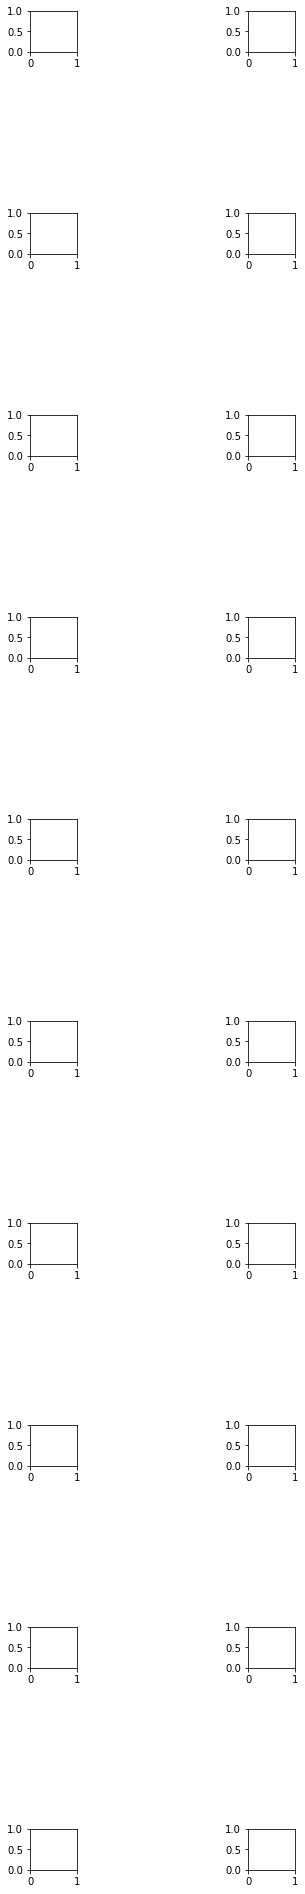

In [95]:
axes_per_metric = 2
fig, axes = plt.subplots(len(metrics), axes_per_metric, figsize=(4 * axes_per_metric, 3 * len(metrics)))
axes = axes.reshape(-1, axes_per_metric)
plt.tight_layout(pad=14)


axes

In [170]:
x = MALogMetric()


In [171]:
x.fig_color

'Figure has not been initialized. Please calculate the metric at least once'

In [172]:
x.calculate(df_bitcoin_org.copy(), axes[0])

Date
2011-06-27         NaN
2011-06-28         NaN
2011-06-29         NaN
2011-06-30         NaN
2011-07-01         NaN
                ...   
2024-01-02    0.598531
2024-01-03    0.602890
2024-01-04    0.599889
2024-01-05    0.601978
2024-01-06    0.604374
Name: Index, Length: 4577, dtype: float64

In [173]:
x.fig_color